# Import des librairies

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du fichier

In [2]:
data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep="\t", encoding='utf_8', low_memory=False)

# Analyse du fichier

In [3]:
data.shape

(320772, 162)

In [4]:
data.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [5]:
data.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

Le jeu de données comporte donc massivement :
Des informations générales sur la fiche produit
Les ingrédients et additifs contenus dans les produits
Des informations nutritionnelles

L'idée d'application est d'estimer un score "Healthy" pour les aliments que nous consommons, en nous basant sur le nutriscore et sur les valeurs énergétiques, nutritionnelles, les additifs, la présence d'huile de palme...
Notre application s'appellera "Score your food"
Pour ce faire, nous choisirons des indicateurs pertinents pour notre étude.

# Traitement valeurs manquantes
Nous avons plusieurs valeurs manquantes dans ce jeu de données. Voyons d'abord voir le pourcentage de valeurs :

In [6]:
data.isnull().mean()*100

code                         0.007170
url                          0.007170
creator                      0.000623
created_t                    0.000935
created_datetime             0.002806
                              ...    
carbon-footprint_100g       99.916452
nutrition-score-fr_100g     31.038245
nutrition-score-uk_100g     31.038245
glycemic-index_100g        100.000000
water-hardness_100g        100.000000
Length: 162, dtype: float64

In [7]:
#pourcentatge de valeurs manquantes
def pourcentage_nan(data=data):
    somme = 0
    for colonne in data.columns:
        somme += data[colonne].isna().sum()
    return (somme / (data.shape[0]*data.shape[1]))*100
pourcentage_nan()

76.22157263195135

Nous avons donc 76% de valeurs manquantes dans notre jeu de données. 


1) Un grand nombre de données n'est pas renseigné pour la plupart des colonnes. Nous décidons donc de supprimer les features contenant moins de 25% de taux de remplissage, pour avoir un jeu de données plus nettoyé sans biaiser le dataset.

In [8]:
# suppression des colonnes avec plus de 75% de valeurs manquantes
data = data.loc[:, data.isnull().mean() < .75]

In [9]:
data.isnull().mean()

code                                       0.000072
url                                        0.000072
creator                                    0.000006
created_t                                  0.000009
created_datetime                           0.000028
last_modified_t                            0.000000
last_modified_datetime                     0.000000
product_name                               0.055373
quantity                                   0.673229
brands                                     0.088574
brands_tags                                0.088599
categories                                 0.736854
categories_tags                            0.736919
categories_fr                              0.736850
countries                                  0.000873
countries_tags                             0.000873
countries_fr                               0.000873
ingredients_text                           0.223866
serving_size                               0.341180
additives_n 

Pour notre analyse, nous allons séparer nos colonnes en plusieurs sous-thématiquesNous devons prendre en compte les nutriments dans notre analyse. Les colonnes sur les nutriments sont mises sur notre dataset avec une fin de nomenclature qui est : "_100g". On crée donc une variable "Nutri_100g" et on convertit toutes les données en numérique.

In [10]:
Nutri_100g = data.columns[(data.columns.str.contains('_100g'))& ~(data.columns.str.contains('energy'))& ~(data.columns.str.contains('score'))]
Nutri_100g

Index(['fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g'],
      dtype='object')

In [11]:
for col in Nutri_100g:
    data[col] = pd.to_numeric(data[col])

C:\Users\nha5600\AppData\Local\Temp/ipykernel_16140/1479007703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col])


On crée des groupes de colonnes suivant le fichier csv mis à disposition : 

In [12]:
general = ['code', 'url', 'product_name', 'creator']
tags = ['brands','categories_fr','countries_fr']
misc = ['ingredients_text','serving_size','additives_fr','states_fr','main_category_fr']
energy = ['energy_100g']
nutrition_score = ['nutrition-score-fr_100g']
grade = ['nutrition_grade_fr']
additives = ['additives_n']
palme = ['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']

Pour notre analyse, nous voyons d'où viennent la plupart de nos produits, afin de proposer des recommandations adaptées aux consommateurs. Nous supprimons les colonnes qui ne nous présentent pas d'intérêt puisque redondantes pour la suite de notre étude :

In [13]:
#Suppression des colonnes de datetime qui n'ont pas d'intérêt 
temps_suppr = ['created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',]

# On garde les colonnes avec le suffixe_fr, qui sont les mêmes colonnes en plusieurs langues
suff_suppr = ['brands_tags',
 'categories',
 'categories_tags',
 'countries',
 'countries_tags',
 'additives',
 'additives_tags',
 'states',
 'states_tags',
 'main_category']

data.drop(suff_suppr, axis=1, inplace=True)
data.drop(temps_suppr, axis=1, inplace=True)

C:\Users\nha5600\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


On suppression les valeurs en doublon dans tout notre dataset :

In [14]:
data.drop_duplicates(inplace=True)

C:\Users\nha5600\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


2) Traitement des NaN : On supprime les lignes qui n'ont pas de nom de code ou de produit (essentiels pour l'analyse) :

In [15]:
data = data.dropna(subset=['code'])

In [16]:
data = data.dropna(subset=['product_name'])

2) Méthodes de traitement des valeurs manquantes : Par le remplacement des valeurs quantitatives (hors énergie et hors nutrition score) par la médiane

In [55]:
data[Nutri_100g] = data[Nutri_100g].fillna(data[Nutri_100g].median())

3) Le même procédé va être utilisé pour le nutriscore, pour ne pas biaiser les données. 

In [19]:
mediane_score = list(data[["nutrition-score-fr_100g"]].quantile(0.5))
print(mediane_score)

[10.0]


On attribue donc la valeur de la médiane pour les valeurs manquantes de notre nutrition_score, puis on transforme les valeurs en entier.

In [20]:
data.loc[data['nutrition-score-fr_100g'].isna(), 'nutrition-score-fr_100g'] = data['nutrition-score-fr_100g'].median()

In [21]:
data["nutrition-score-fr_100g"]=data["nutrition-score-fr_100g"].astype('int')

4) Traitement des valeurs manquantes : On supprime les "NaN" présentes pour notre data_nutrition_grade. En effet, en remplaçant les données par la valeur médiane (obtenue en allant sur la médiane du nutriscore correspondant à 10 et donc à c), nos analyses seront biaisées et faussées.

In [22]:
data = data.dropna(subset=['nutrition_grade_fr'])

In [23]:
data.nutrition_grade_fr.value_counts()

d    62019
c    44960
e    42377
a    35297
b    33810
Name: nutrition_grade_fr, dtype: int64

Pour être utile dans notre score, nous transformons les "string" en "catégories". 

In [24]:
scores = ['a','b','c','d','e']
ordered_score = pd.api.types.CategoricalDtype(ordered = True,categories = scores)
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].astype(ordered_score)

In [25]:
data.nutrition_grade_fr.dtypes

CategoricalDtype(categories=['a', 'b', 'c', 'd', 'e'], ordered=True)

Nous obtenons des grades sans NaN et pouvons donc tracer un diagramme circulaire pour représenter les catégories :

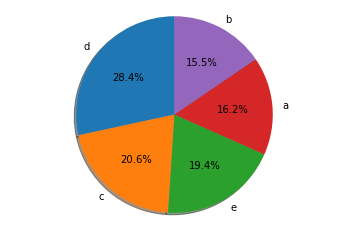

In [26]:
proportion_grade = data["nutrition_grade_fr"].value_counts() 
labels = proportion_grade.index
fig, ax = plt.subplots()
ax.pie(proportion_grade, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
plt.show()

In [27]:
data.dtypes

code                                         object
url                                          object
creator                                      object
product_name                                 object
quantity                                     object
brands                                       object
categories_fr                                object
countries_fr                                 object
ingredients_text                             object
serving_size                                 object
additives_n                                 float64
additives_fr                                 object
ingredients_from_palm_oil_n                 float64
ingredients_that_may_be_from_palm_oil_n     float64
nutrition_grade_fr                         category
pnns_groups_1                                object
pnns_groups_2                                object
states_fr                                    object
main_category_fr                             object
energy_100g 

5) Méthode de traitement des NaN : Par réduction des dimensions - Cette méthode ne permet pas d'imputer les valeurs énergetiques nécessaires. On va donc attribuer la valeur de 0 aux valeurs manquantes d'énergie, cela ne biaisera pas nos données étant donné qu'elles ne concernent que très peu de valeurs.

In [ ]:
#On applique le KNN pour notre variable energie_100g
#from sklearn.impute import KNNImputer
#knn = ['energy_100g']
#data_echantillon = data[knn].sample(frac=0.25, random_state=1)
#imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
#imputer.fit(data_echantillon)

In [30]:
# Puis on applique le modèle sur l'ensemble des données
#data_apply = imputer.transform(data[knn])

In [31]:
#data_apply_df = pd.DataFrame(data_apply, columns=knn)

In [32]:
#data_apply_df

,energy_100g
0,2243.0
1,1941.0
2,2540.0
3,1833.0
4,2230.0
...,...
218458,1477.0
218459,1643.0
218460,2406.0
218461,21.0


In [33]:
#data.loc[data['energy_100g'].isna(), 'energy_100g'] = data['energy_100g'].mean()

C:\Users\nha5600\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [28]:
data['energy_100g'].fillna(0)

1         2243.0
2         1941.0
3         2540.0
7         1833.0
12        2230.0
           ...  
320742    1477.0
320751    1643.0
320757    2406.0
320763      21.0
320768       0.0
Name: energy_100g, Length: 218463, dtype: float64

In [29]:
data['energy_100g']

1         2243.0
2         1941.0
3         2540.0
7         1833.0
12        2230.0
           ...  
320742    1477.0
320751    1643.0
320757    2406.0
320763      21.0
320768       0.0
Name: energy_100g, Length: 218463, dtype: float64

Méthode de traitement des NaN : Si on observe des valeurs manquantes au niveau des additifs et de l'huile de palme, nous considérerons par mesure de prévention qu'ils en contiennent. Nous utiliserons donc la moyenne de ces deux variables.

In [30]:
data.loc[data['additives_n'].isna(), 'additives_n'] = data['additives_n'].mean()

In [31]:
data.loc[data['ingredients_from_palm_oil_n'].isna(), 'ingredients_from_palm_oil_n'] = data['ingredients_from_palm_oil_n'].mean()

In [53]:
data["additives_n"]=data["additives_n"].astype('int')
data["ingredients_from_palm_oil_n"]=data["ingredients_from_palm_oil_n"].astype('int')

In [32]:
data['additives_n'].isnull()

1         False
2         False
3         False
7         False
12        False
          ...  
320742    False
320751    False
320757    False
320763    False
320768    False
Name: additives_n, Length: 218463, dtype: bool

# Gestion des outliers

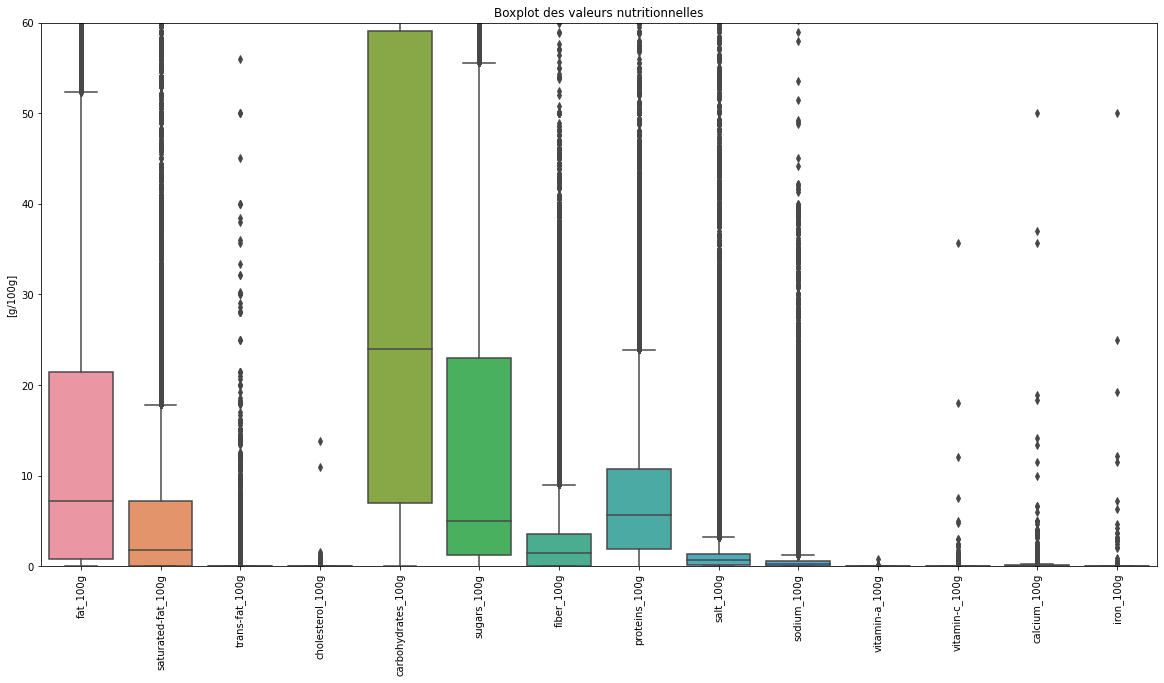

In [35]:
import seaborn as sb
plt.figure(figsize = [20,10])
sb.boxplot(x="variable", y="value", data=data[Nutri_100g].melt())
plt.title("Boxplot des valeurs nutritionnelles")
plt.ylim([0,60])
plt.xlabel("")
plt.ylabel("[g/100g]")
plt.xticks(rotation = 90);
plt.show()

Nous traçons le boxplot de notre variable, pour identifier également la présence ou non d'outliers :

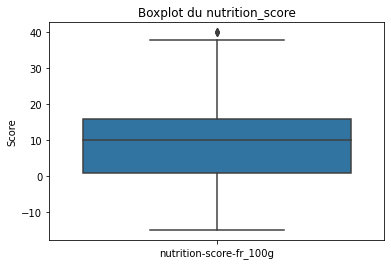

In [36]:
sb.boxplot(x="variable", y="value", data=data[nutrition_score].melt())
plt.title("Boxplot du nutrition_score")
plt.xlabel("")
plt.ylabel("Score")
plt.show()

Pas d'outliers pour le nutriscore, qui est censé être compris entre -15 et 40.

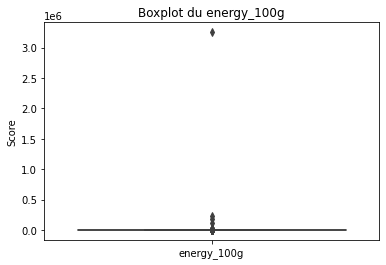

In [41]:
sns.boxplot(x="variable", y="value", data=data[energy].melt())
plt.title("Boxplot du energy_100g")
plt.xlabel("")
plt.ylabel("Score")
plt.show()

In [42]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,218463.000000,218463.000000,194892.000000,2.182770e+05,201014.000000,218277.000000,135334.000000,137079.000000,200986.000000,218277.000000,191722.000000,218277.000000,218277.000000,218277.000000,131964.000000,132800.000000,135196.000000,134502.000000,218463.000000,218463.000000
mean,1.982698,0.020996,0.057037,1.195365e+03,13.336950,4.954429,0.071203,0.019241,33.250102,15.003938,2.829172,7.778697,1.646217,0.648117,0.000144,0.008269,0.112090,0.003103,9.151724,9.044406
std,2.387734,0.137030,0.274639,7.031278e+03,16.192683,7.650245,1.559398,0.366693,28.341996,21.191430,13.078246,8.131459,138.275500,54.439173,0.002323,0.437458,2.753802,0.172313,9.052588,9.180977
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,0.000000,-3.570000,0.000000,0.000000,0.000000,-0.002100,0.000000,-0.000260,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,4.520000e+02,0.830750,0.000000,0.000000,0.000000,7.000000,1.280000,0.000000,1.900000,0.100000,0.039370,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.982698,0.000000,0.000000,1.193000e+03,7.140000,1.790000,0.000000,0.000000,24.000000,5.000000,1.500000,5.700000,0.650000,0.255906,0.000000,0.000000,0.036000,0.001010,10.000000,9.000000
75%,3.000000,0.000000,0.000000,1.715000e+03,21.430000,7.140000,0.000000,0.020000,59.090000,23.000000,3.600000,10.710000,1.361440,0.536000,0.000101,0.002800,0.107000,0.002400,16.000000,16.000000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,550.000000,369.000000,95.238000,209.380000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,0.800000,152.941200,694.737000,50.000000,40.000000,40.000000


Les variables suffixées avec _100g nous indiquent la quantité de nutriment pour 100 grammes de produit. Les valeurs renseignées ne peuvent donc logiquement pas excéder 100. Nous allons donc supprimer les lignes dont au moins 1 des variables de nutriments est supérieur au seuil.
Par ailleurs, l'énergie pour 100g ne doit pas être supérieure à 37 kJ(https://en.wikipedia.org/wiki/Food_energy) d'où notre limite à 3700J.
Nous pouvons soumettre le nombre d'additifs à un nombre maximal, mais aucune source ne concorde à un nombre maximal d'additifs par produit.Nous traçons donc une répartition pour avoir le seuil maximal dans notre dataset.

In [43]:
data = data[~(data[Nutri_100g]>100).any(axis=1)]

In [44]:
data = data[~(data[Nutri_100g]<0).any(axis=1)]

In [45]:
data = data[~(data['energy_100g']>3700)]

Nous pouvons soumettre le nombre d'additifs à un nombre maximal, mais aucune source ne concorde à un nombre maximal d'additifs par produit. D’après notre vision et nos recherches, on soumet le nombre d’additifs maximal à 6 par produit.

In [47]:
data = data[~(data['additives_n']>6)]

In [48]:
data.shape

(206506, 36)

In [56]:
data

,code,url,creator,product_name,quantity,brands,categories_fr,countries_fr,ingredients_text,serving_size,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,Banana Chips Sweetened (Whole),NaN,NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),...,3.6,3.57,0.00000,0.000000,0.0,0.0214,0.000,0.00129,14,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,Peanuts,NaN,Torn & Glasser,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),...,7.1,17.86,0.63500,0.250000,0.0,0.0000,0.071,0.00129,0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,Organic Salted Nut Mix,NaN,Grizzlies,NaN,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),...,7.1,17.86,1.22428,0.482000,0.0,0.0000,0.143,0.00514,12,12.0
7,0000000016124,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,Organic Muesli,NaN,Daddy's Muesli,NaN,États-Unis,"Org oats, org hemp granola (org oats, evaporat...",64 g (0.5 cup),...,9.4,14.06,0.13970,0.055000,0.0,0.0000,0.062,0.00422,7,7.0
12,0000000016872,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,Zen Party Mix,NaN,Sunridge,NaN,États-Unis,"Roasted peanuts (peanuts, peanut or canola oil...",30 g (0.25 cup),...,6.7,16.67,1.60782,0.633000,0.0,0.0000,0.133,0.00360,12,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320742,9787461062105,http://world-fr.openfoodfacts.org/produit/9787...,usda-ndb-import,Natural Cassava,NaN,Industria De Casabe Paul,NaN,États-Unis,Cassava.,85 g (85 GRM),...,4.7,1.18,0.03048,0.012000,0.0,0.0000,0.000,0.00127,-1,-1.0
320751,9847548283004,http://world-fr.openfoodfacts.org/produit/9847...,drmalabar,Tartines craquantes bio au sarrasin,NaN,Le Pain des fleurs,"Aliments et boissons à base de végétaux,Alimen...",France,NaN,NaN,...,5.9,13.00,0.68000,0.267717,0.0,0.0000,0.035,0.00380,-4,-4.0
320757,9900000000233,http://world-fr.openfoodfacts.org/produit/9900...,kiliweb,Amandes,NaN,Biosic,NaN,France,NaN,NaN,...,12.2,21.22,0.10000,0.039370,0.0,0.0000,0.035,0.00102,0,0.0
320763,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,Thé vert Earl grey,50 g,Lobodis,"Aliments et boissons à base de végétaux,Boisso...",France,"thé vert, arôme naturel bergamote avec autres ...",NaN,...,0.2,0.50,0.02540,0.010000,0.0,0.0000,0.035,0.00102,2,0.0


In [50]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,206506.000000,206506.000000,183136.000000,206334.000000,189285.000000,206334.000000,127148.000000,128965.000000,189270.000000,206334.000000,181455.000000,206334.000000,206334.000000,206334.000000,124067.000000,124903.000000,127184.000000,126499.000000,206506.000000,206506.000000
mean,1.580887,0.018390,0.041876,1170.224068,13.479147,4.982162,0.060338,0.019151,32.567460,14.630556,2.858253,7.879698,1.244990,0.490154,0.000146,0.006997,0.097511,0.003060,9.021999,8.910274
std,1.570684,0.126326,0.229358,764.919741,16.135444,7.512235,0.925663,0.335579,28.221772,19.556623,4.545010,8.194346,4.027536,1.585640,0.002385,0.125701,0.458429,0.176393,9.120341,9.249676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,444.000000,0.820000,0.000000,0.000000,0.000000,6.670000,1.200000,0.000000,1.800000,0.100000,0.039370,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1180.000000,7.140000,1.790000,0.000000,0.000000,22.470000,4.920000,1.500000,5.730000,0.635000,0.250000,0.000000,0.000000,0.035000,0.001020,9.000000,9.000000
75%,2.000000,0.000000,0.000000,1732.000000,22.000000,7.140000,0.000000,0.020000,58.180000,22.000000,3.600000,11.000000,1.361440,0.536000,0.000105,0.002800,0.105000,0.002400,16.000000,16.000000
max,6.000000,2.000000,4.000000,3700.000000,100.000000,100.000000,100.000000,95.238000,100.000000,100.000000,100.000000,100.000000,100.000000,39.370079,0.800000,35.714300,82.000000,50.000000,40.000000,37.000000


# Export en CSV

In [57]:
data.to_csv("nutri_nettoyé.csv", index=False)